# Progetto di Programmazione di Applicazioni Data Intensive: Rilevamento Frodi su Carte di Credito

**Autore:** Alessandro Valmori, alessandro.valmori2@studio.unibo.it, 0001089308
**Data:** 25 Maggio 2025
**Corso:** Programmazione di Applicazioni Data Intensive

## 1. Introduzione e Obiettivo del Progetto

Questo progetto si concentra sull'analisi di un dataset di transazioni con carte di credito al fine di addestrare e validare modelli di classificazione capaci di identificare transazioni fraudolente. Le frodi con carta di credito rappresentano un problema significativo per le istituzioni finanziarie e i consumatori, rendendo cruciale lo sviluppo di sistemi di rilevamento efficaci.

L'obiettivo principale è esplorare il dataset, preparare i dati per il machine learning, addestrare almeno due (preferibilmente tre o più) modelli di classificazione, valutarne le performance con metriche appropriate (data la natura sbilanciata del problema) e ottimizzare gli iperparametri di almeno un modello.

Il dataset utilizzato è "Credit Card Fraud Detection" disponibile su Kaggle, noto per il suo forte sbilanciamento tra classi (pochissime frodi rispetto alle transazioni legittime).

**Struttura del Notebook:**
1.  Introduzione e Obiettivo del Progetto
2.  Setup dell'Ambiente e Caricamento Librerie
3.  Descrizione e Caricamento del Dataset
4.  Analisi Esplorativa dei Dati (EDA)
5.  Preparazione dei Dati per il Machine Learning
6.  Addestramento e Validazione dei Modelli di Classificazione
    * 6.1 Logistic Regression (Baseline)
    * 6.2 Random Forest Classifier
    * 6.3 XGBoost Classifier (Modello Aggiuntivo)
7.  Ottimizzazione degli Iperparametri (con RandomizedSearchCV)
8.  Confronto Finale dei Modelli e Conclusioni

## 2. Setup dell'Ambiente e Caricamento Librerie

In questa sezione, importiamo tutte le librerie Python necessarie per l'analisi dei dati, la visualizzazione, il preprocessing, la modellazione e la valutazione.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline


## 3. Descrizione e Caricamento del Dataset

Utilizziamo il dataset "Credit Card Fraud Detection" da Kaggle. Questo dataset contiene transazioni effettuate con carte di credito europee nel settembre 2013. Presenta 284.807 transazioni, di cui solo 492 sono fraudolente (circa lo 0.172%).
Le feature `V1` a `V28` sono il risultato di una trasformazione PCA applicata ai dati originali per ragioni di confidenzialità. Le uniche feature non trasformate da PCA sono `Time` (secondi trascorsi tra ogni transazione e la prima transazione nel dataset) e `Amount` (l'importo della transazione). La variabile target è `Class`, che vale 1 in caso di frode e 0 altrimenti.

Procediamo con il caricamento e una prima ispezione del dataset.

In [2]:
# Caricamento del dataset
try:
    #read ../data/creditcard.csv
    df = pd.read_csv('data/creditcard.csv')
    print("Dataset caricato con successo.")
    print(f"Dimensioni del dataset: {df.shape}")
except FileNotFoundError:
    print("Errore: creditcard.csv non trovato. Assicurati che il file sia nella directory corretta.")
    # Qui potresti aggiungere istruzioni per scaricare il dataset se non presente
    # exit() # O gestire l'errore come preferisci

Dataset caricato con successo.
Dimensioni del dataset: (284807, 31)


## 4. Analisi Esplorativa dei Dati (EDA)

L'Analisi Esplorativa dei Dati (EDA) è fondamentale per comprendere la struttura del dataset, le distribuzioni delle variabili, le correlazioni e identificare eventuali problemi o pattern interessanti.

### 4.1. Analisi della Variabile Target (`Class`)
Iniziamo analizzando la distribuzione della variabile target per quantificare lo sbilanciamento.

In [3]:
# Visualizza le prime righe
print("\nPrime 5 righe del dataset:")
print(df.head())

# Informazioni generali sul dataset
print("\nInformazioni sul dataset:")
df.info()

# Verifica di valori nulli
print("\nValori nulli per colonna:")
print(df.isnull().sum())

# Eventuale eliminazione di colonne (se ce ne fossero di palesemente non informative)
# In questo dataset, tutte le colonne sono rilevanti o da investigare.
# Ad esempio, 'Time' potrebbe essere trasformata o eliminata se non utile.


Prime 5 righe del dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

    

In [4]:
print(f"Valori NaN nella colonna 'Class' prima della pulizia: {df['Class'].isnull().sum()}")

# Rimuovi le righe dove 'Class' è NaN
df_cleaned = df.dropna(subset=['Class'])

# Verifica se sono stati rimossi dei NaN
if df_cleaned.shape[0] < df.shape[0]:
    print(f"Rimosse {df.shape[0] - df_cleaned.shape[0]} righe con NaN nella colonna 'Class'.")
    print(f"Nuove dimensioni del DataFrame: {df_cleaned.shape}")
else:
    print("Nessun NaN trovato nella colonna 'Class'.")
# --- FINE AGGIUNTA ---

# Usa il DataFrame pulito per creare X e y
X_original = df_cleaned.drop('Class', axis=1)
y_original = df_cleaned['Class']

# Suddivisione in training e test set, stratificando su y
# Questo split viene fatto PRIMA di qualsiasi scaling specifico per il modello o SMOTE
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)

print(f"\nForma di X_train_orig: {X_train_orig.shape}, X_test_orig: {X_test_orig.shape}")
print(f"Distribuzione classi in y_train_orig:\n{y_train_orig.value_counts(normalize=True)}")
print(f"Distribuzione classi in y_test_orig:\n{y_test_orig.value_counts(normalize=True)}")

# Salva y_test per la valutazione finale (y_test_orig è la stessa di y_test nel tuo codice)
y_test = y_test_orig.copy()

Valori NaN nella colonna 'Class' prima della pulizia: 0
Nessun NaN trovato nella colonna 'Class'.

Forma di X_train_orig: (227845, 30), X_test_orig: (56962, 30)
Distribuzione classi in y_train_orig:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Distribuzione classi in y_test_orig:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


Come osservato, il dataset è estremamente sbilanciato: solo lo 0.17% delle transazioni sono etichettate come fraudolente. Questo sbilanciamento è una caratteristica cruciale che influenzerà la scelta delle metriche di valutazione e delle tecniche di modellazione (ad esempio, la necessità di tecniche di ricampionamento come SMOTE o l'uso di pesi di classe).

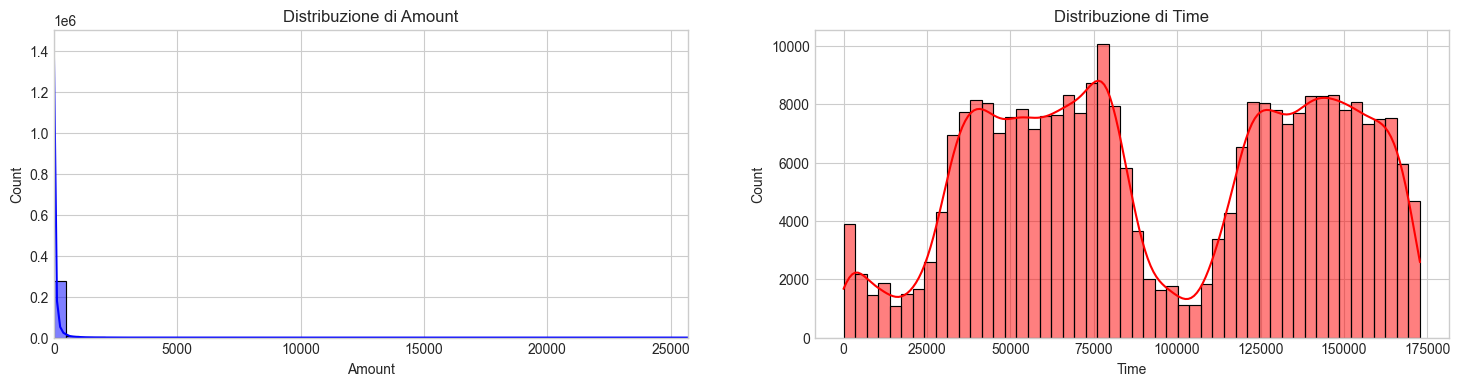

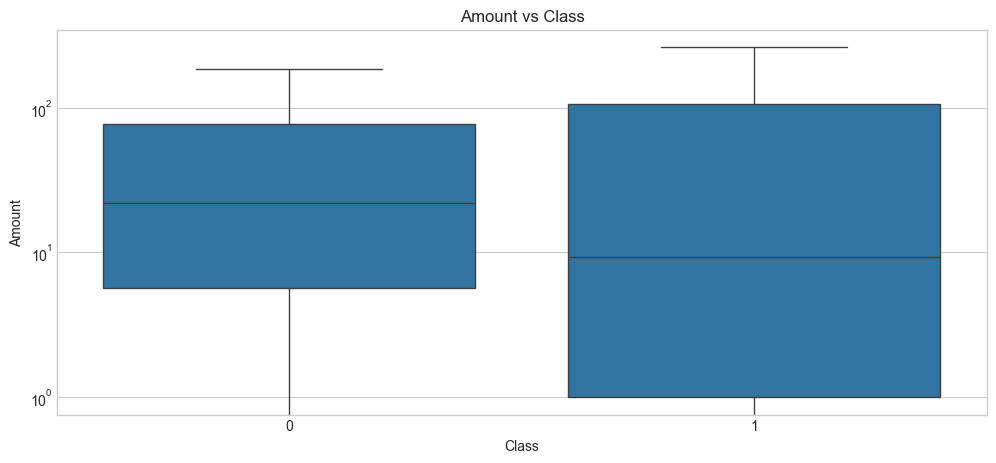

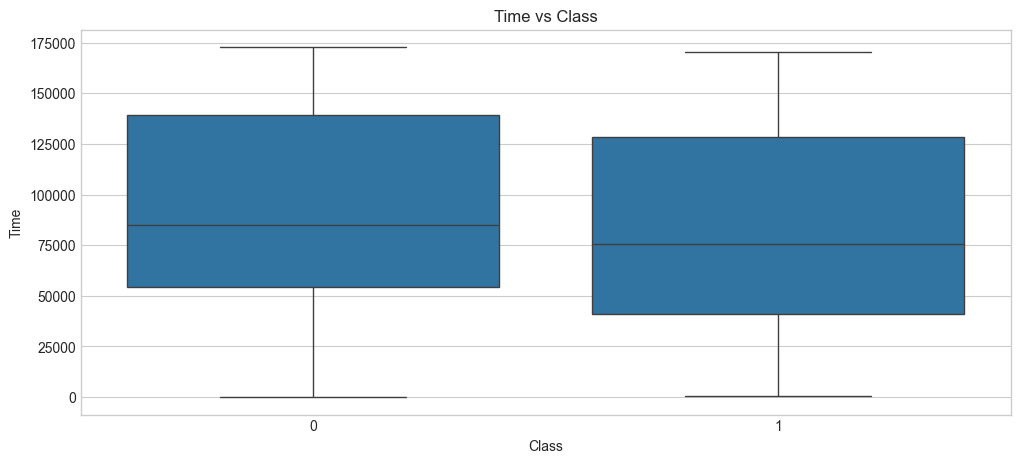

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df['Amount'], ax=ax[0], color='b', bins=50, kde=True)
ax[0].set_title('Distribuzione di Amount')
ax[0].set_xlim([min(df['Amount']), max(df['Amount'])]) # Potrebbe essere necessario limitare xlim per visualizzare meglio

sns.histplot(df['Time'], ax=ax[1], color='r', bins=50, kde=True)
ax[1].set_title('Distribuzione di Time')
plt.show()

# Confronto di Amount e Time per transazioni fraudolente e non
plt.figure(figsize=(12, 5))
sns.boxplot(x='Class', y='Amount', data=df, showfliers=False) # showfliers=False per non mostrare gli outlier e vedere meglio le box
plt.title('Amount vs Class')
plt.yscale('log') # Scala logaritmica può aiutare per 'Amount'
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(x='Class', y='Time', data=df)
plt.title('Time vs Class')
plt.show()

**Osservazioni su `Time` e `Amount`:**
* **Amount:** La distribuzione degli importi delle transazioni è fortemente asimmetrica a destra (right-skewed), con la maggior parte delle transazioni di piccolo importo e alcune transazioni di importo molto elevato. Il boxplot, specialmente con scala logaritmica sull'asse y, mostra che le transazioni fraudolente tendono ad avere una distribuzione degli importi leggermente diversa, sebbene ci sia una notevole sovrapposizione. L'uso di `showfliers=False` nel boxplot aiuta a visualizzare meglio il corpo principale della distribuzione senza essere distratti dagli outlier estremi.
* **Time:** La feature `Time` rappresenta i secondi trascorsi dalla prima transazione. L'istogramma mostra un pattern bimodale, che potrebbe indicare cicli di attività giornalieri (es. meno transazioni durante la notte). Il boxplot che confronta `Time` per le due classi non rivela pattern immediatamente evidenti o distintivi per le frodi basati solo su questa feature grezza, anche se si nota una leggera differenza nella mediana. Per questo progetto, data la sua natura (secondi trascorsi), e la difficoltà di interpretazione diretta senza conoscere il momento esatto di inizio, procederemo inizialmente scalando questa feature. Ulteriori analisi o feature engineering (es. trasformazione in ore del giorno) potrebbero essere considerate in sviluppi futuri ma sono fuori dallo scopo minimo di questo progetto.

### 4.3. Analisi delle Correlazioni
Esaminiamo la correlazione tra le features e la variabile target. Poiché le features `V1-V28` sono componenti PCA, ci aspettiamo che siano largamente incorrelate tra loro. La correlazione con la classe target può invece darci indicazioni sulle features potenzialmente più informative.


Correlazione delle features con la classe target:
Class     1.000000
V11       0.154876
V4        0.133447
V2        0.091289
V21       0.040413
V19       0.034783
V20       0.020090
V8        0.019875
V27       0.017580
V28       0.009536
Amount    0.005632
V26       0.004455
V25       0.003308
V22       0.000805
V23      -0.002685
V15      -0.004223
V13      -0.004570
V24      -0.007221
Time     -0.012323
V6       -0.043643
V5       -0.094974
V9       -0.097733
V1       -0.101347
V18      -0.111485
V7       -0.187257
V3       -0.192961
V16      -0.196539
V10      -0.216883
V12      -0.260593
V14      -0.302544
V17      -0.326481
Name: Class, dtype: float64


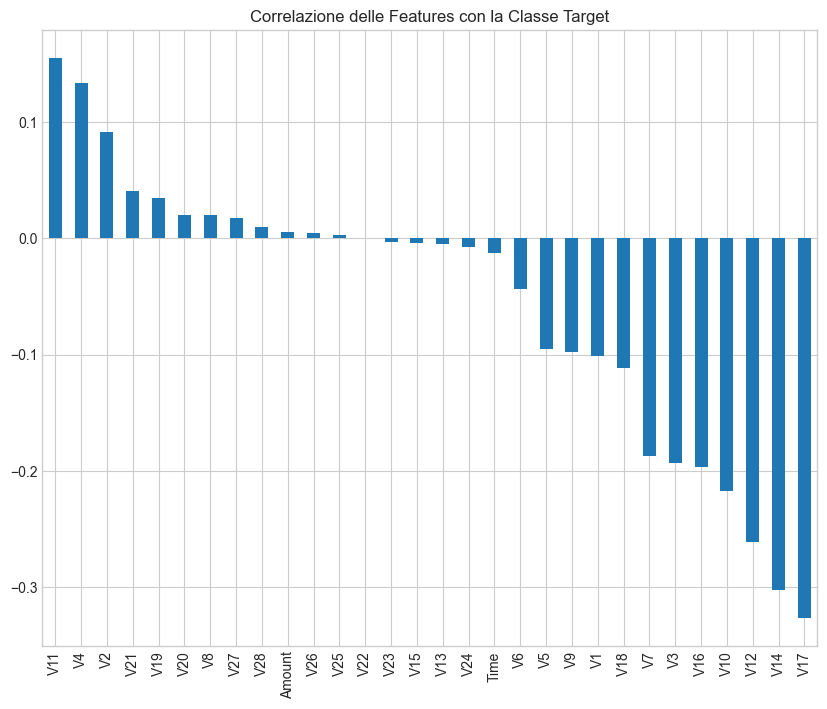

In [6]:
# Correlazione con la variabile target 'Class'
correlation_with_target = df.corr()['Class'].sort_values(ascending=False)
print("\nCorrelazione delle features con la classe target:")
print(correlation_with_target)

plt.figure(figsize=(10, 8))
correlation_with_target.drop('Class').plot(kind='bar')
plt.title('Correlazione delle Features con la Classe Target')
plt.show()

**Osservazioni sulle Correlazioni:**
Il grafico a barre mostra le correlazioni di Pearson tra ciascuna feature e la variabile `Class`.
* Alcune features `V` mostrano una correlazione negativa più marcata con la classe `Class` (es. `V17`, `V14`, `V12`, `V10`). Questo suggerisce che valori più bassi di queste features sono associati a una maggiore probabilità di frode.
* Altre features `V` (es. `V11`, `V4`, `V2`) mostrano una correlazione positiva, indicando che valori più alti potrebbero essere associati a frodi.
* `Amount` e `Time` mostrano correlazioni molto deboli con `Class`. Tuttavia, la correlazione lineare non cattura relazioni non lineari, che potrebbero comunque esistere. Lo scaling di `Amount` e `Time` sarà importante per i modelli sensibili alla scala delle features.

### 4.4. Distribuzione di Alcune Features PCA per Classe
Visualizziamo le distribuzioni di densità (KDE) per alcune delle features PCA che hanno mostrato una correlazione più significativa con la classe target, separando le transazioni legittime da quelle fraudolente. Questo può aiutarci a capire se ci sono differenze visibili nelle distribuzioni.

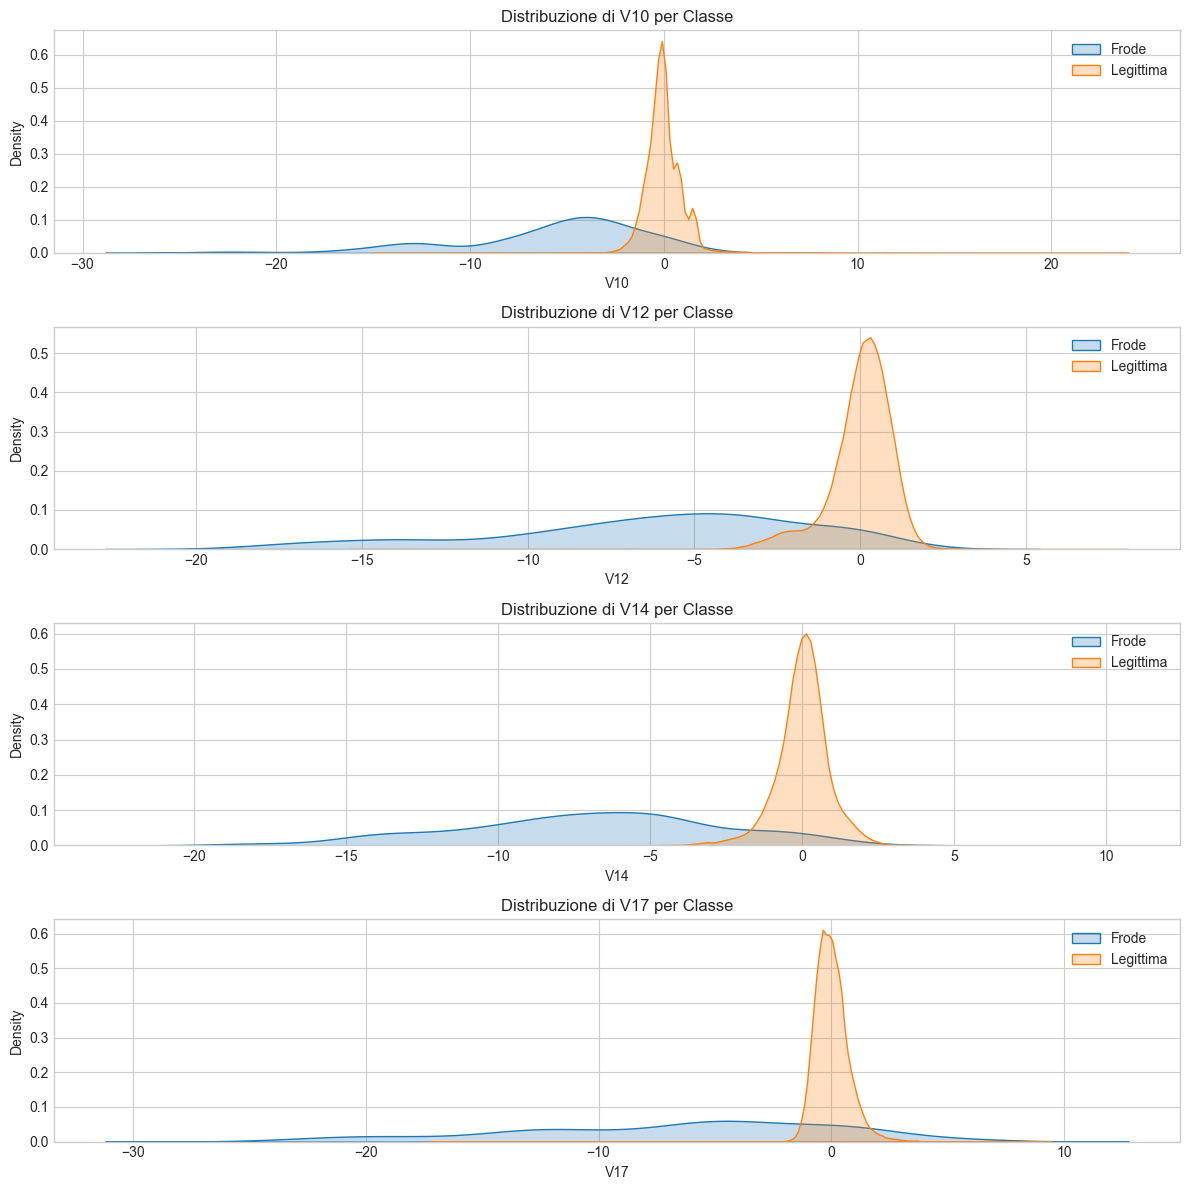

In [7]:
# Esempio: plot di alcune features V1-V28 per le due classi
var_to_plot = ['V10', 'V12', 'V14', 'V17'] # Features spesso indicative
plt.figure(figsize=(12, len(var_to_plot)*3))
for i, var in enumerate(var_to_plot):
    plt.subplot(len(var_to_plot), 1, i+1)
    sns.kdeplot(df[var][df.Class == 1], label="Frode", fill=True)
    sns.kdeplot(df[var][df.Class == 0], label="Legittima", fill=True)
    plt.title(f'Distribuzione di {var} per Classe')
    plt.legend()
plt.tight_layout()
plt.show()

## 5. Preparazione dei Dati per il Machine Learning

Questa fase include diversi passaggi cruciali:
1.  **Scaling delle Features**: Le features `Time` e `Amount` sono su scale molto diverse rispetto alle features PCA `V1-V28` (che sono già standardizzate). È importante scalarle per evitare che dominino i modelli sensibili alla scala (es. Logistic Regression, SVM, Reti Neurali). Useremo `RobustScaler`, che è meno sensibile agli outlier rispetto a `StandardScaler`.
2.  **Separazione Features e Target**: Isoleremo la variabile target `Class` (y) dalle variabili predittive (X).
3.  **Suddivisione in Training e Test Set**: Divideremo il dataset in un insieme di addestramento e un insieme di test. È fondamentale usare la stratificazione sulla variabile target (`stratify=y`) per assicurare che la proporzione di classi fraudolente e legittime sia mantenuta in entrambi i set, data la forte imbalanced nature.
4.  **Gestione dello Sbilanciamento delle Classi**: Applicheremo una tecnica di ricampionamento, specificamente SMOTE (Synthetic Minority Over-sampling Technique), *solo sul training set*. SMOTE genera campioni sintetici per la classe minoritaria (frodi) per bilanciare la distribuzione delle classi, aiutando il modello a imparare meglio le caratteristiche delle frodi senza semplicemente predire sempre la classe maggioritaria. È cruciale applicare SMOTE *dopo* la suddivisione in train/test per evitare data leakage (informazioni del test set che influenzano l'addestramento).

In [8]:
# File: data_preparation_scaling.py
# 3.2. Scaling delle Features 'Time' e 'Amount'
import pandas as pd
from sklearn.preprocessing import RobustScaler
# Assumere che X_train_orig, X_test_orig siano definiti dalla cella precedente

# Scaler per 'Amount'
scaler_amount = RobustScaler()
X_train_scaled_amount = scaler_amount.fit_transform(X_train_orig['Amount'].values.reshape(-1, 1))
X_test_scaled_amount = scaler_amount.transform(X_test_orig['Amount'].values.reshape(-1, 1))

# Scaler per 'Time'
scaler_time = RobustScaler()
X_train_scaled_time = scaler_time.fit_transform(X_train_orig['Time'].values.reshape(-1, 1))
X_test_scaled_time = scaler_time.transform(X_test_orig['Time'].values.reshape(-1, 1))

# Creare i nuovi DataFrame di training e test con le feature scalate
X_train_prepared = X_train_orig.copy()
X_test_prepared = X_test_orig.copy()

X_train_prepared['scaled_amount'] = X_train_scaled_amount
X_train_prepared['scaled_time'] = X_train_scaled_time
X_test_prepared['scaled_amount'] = X_test_scaled_amount
X_test_prepared['scaled_time'] = X_test_scaled_time

# Rimuovere le colonne originali 'Time' e 'Amount'
X_train_prepared.drop(['Time', 'Amount'], axis=1, inplace=True)
X_test_prepared.drop(['Time', 'Amount'], axis=1, inplace=True)

print("\nDataset di training preparato (prime righe):")
print(X_train_prepared.head())
print(f"Forma di X_train_prepared: {X_train_prepared.shape}")

print("\nDataset di test preparato (prime righe):")
print(X_test_prepared.head())
print(f"Forma di X_test_prepared: {X_test_prepared.shape}")

# Gli scaler (scaler_amount, scaler_time) verranno salvati successivamente per il backend


Dataset di training preparato (prime righe):
              V1        V2        V3        V4        V5        V6        V7  \
265518  1.946747 -0.752526 -1.355130 -0.661630  1.502822  4.024933 -1.479661   
180305  2.035149 -0.048880 -3.058693  0.247945  2.943487  3.298697 -0.002192   
42664  -0.991920  0.603193  0.711976 -0.992425 -0.825838  1.956261 -2.212603   
198723  2.285718 -1.500239 -0.747565 -1.668119 -1.394143 -0.350339 -1.427984   
82325  -0.448747 -1.011440  0.115903 -3.454854  0.715771 -0.147490  0.504347   

              V8        V9       V10  ...       V21       V22       V23  \
265518  1.139880  1.406819 -0.157403  ...  0.076197  0.297537  0.307915   
180305  0.674782  0.045826  0.284864  ...  0.038628  0.228197  0.035542   
42664  -5.037523  0.000772 -2.009561  ... -2.798352  0.109526 -0.436530   
198723  0.010010 -1.118447  1.756121  ... -0.139670  0.077013  0.208310   
82325  -0.113817 -0.044782 -0.558955  ... -0.243245 -0.173298 -0.006692   

             V24      

Addestramento modello XGBoost preliminare per feature importance (su dati originali scalati)...


/home/siralex/.cache/pypoetry/virtualenvs/credit-card-j7SKsNum-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:15:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Modello XGBoost preliminare addestrato.

Feature Importances calcolate da XGBoost (su training set originale scalato):
          feature  importance
13            V14    0.626459
3              V4    0.057104
11            V12    0.041454
7              V8    0.021751
6              V7    0.017657
28  scaled_amount    0.016332
19            V20    0.015917
25            V26    0.014048
9             V10    0.013529
12            V13    0.012994
5              V6    0.012255
26            V27    0.011986
17            V18    0.011298
18            V19    0.009886
21            V22    0.009883


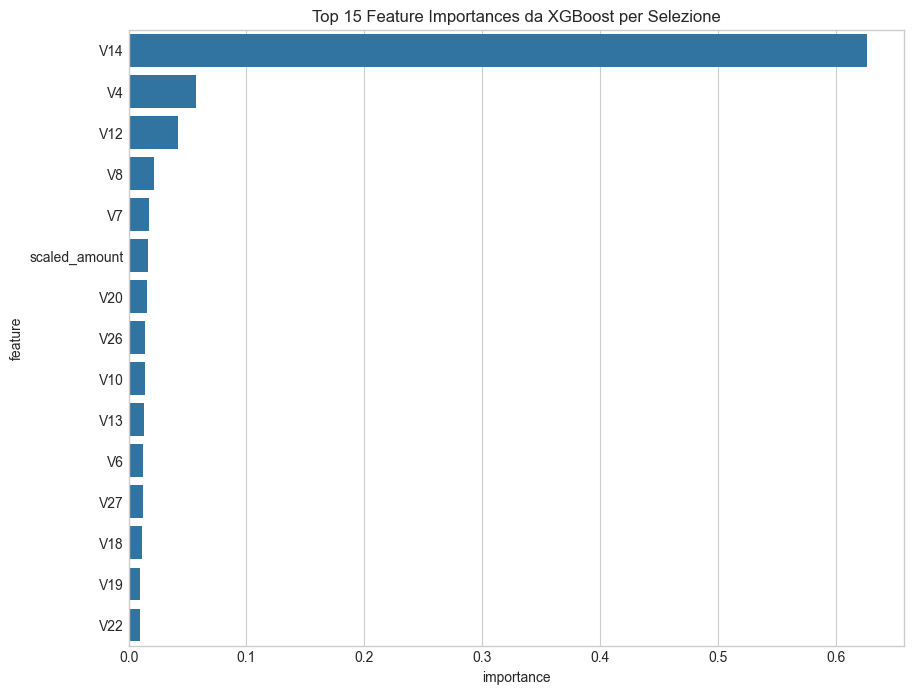


Selezionate le top 15 feature: ['V14', 'V4', 'V12', 'V8', 'V7', 'scaled_amount', 'V20', 'V26', 'V10', 'V13', 'V6', 'V27', 'V18', 'V19', 'V22']

Nuova forma di X_train_fs (feature selezionate): (227845, 15)
Nuova forma di X_test_fs (feature selezionate): (56962, 15)
--- Fine Selezione Feature (PRIMA di SMOTE) ---


In [9]:
N_FEATURES_TO_SELECT = 15 # Decisione progettuale: numero di feature da selezionare

# Addestrare un modello XGBoost su X_train_prepared per ottenere le feature importances
# Per dataset sbilanciati, scale_pos_weight può aiutare XGBoost durante il fitting per le importances
# scale_pos_weight = count(negative_class) / count(positive_class)
scale_pos_weight = y_train_orig.value_counts()[0] / y_train_orig.value_counts()[1]

print("Addestramento modello XGBoost preliminare per feature importance (su dati originali scalati)...")
xgb_for_importance = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False, # Per versioni recenti
    random_state=42,
    scale_pos_weight=scale_pos_weight # Per gestire lo sbilanciamento durante il calcolo dell'importanza
)

xgb_for_importance.fit(X_train_prepared, y_train_orig)
print("Modello XGBoost preliminare addestrato.")

importances_xgb_fs = pd.DataFrame({
    'feature': X_train_prepared.columns,
    'importance': xgb_for_importance.feature_importances_
})
importances_xgb_fs = importances_xgb_fs.sort_values('importance', ascending=False)

print("\nFeature Importances calcolate da XGBoost (su training set originale scalato):")
print(importances_xgb_fs.head(N_FEATURES_TO_SELECT))

plt.figure(figsize=(10, 8))
plt.title(f'Top {N_FEATURES_TO_SELECT} Feature Importances da XGBoost per Selezione')
sns.barplot(x='importance', y='feature', data=importances_xgb_fs.head(N_FEATURES_TO_SELECT))
plt.show()

# Selezionare le N feature più importanti
selected_features = importances_xgb_fs.head(N_FEATURES_TO_SELECT)['feature'].tolist()
print(f"\nSelezionate le top {N_FEATURES_TO_SELECT} feature: {selected_features}")

# Creare i nuovi dataset con solo le feature selezionate
X_train_fs = X_train_prepared[selected_features]
X_test_fs = X_test_prepared[selected_features] # Applicare anche al test set

print(f"\nNuova forma di X_train_fs (feature selezionate): {X_train_fs.shape}")
print(f"Nuova forma di X_test_fs (feature selezionate): {X_test_fs.shape}")
print("--- Fine Selezione Feature (PRIMA di SMOTE) ---")

In [10]:
# File: data_preparation_smote.py
# 3.4. Applicazione di SMOTE (DOPO feature selection, solo su training set)
from imblearn.over_sampling import SMOTE
# Assumere X_train_fs, y_train_orig siano definiti

print(f"\nDistribuzione classi in y_train_orig PRIMA di SMOTE (usato con X_train_fs): \n{y_train_orig.value_counts()}")

smote = SMOTE(random_state=42)
# X_train_smote_fs e y_train_smote verranno usati per i modelli base
X_train_smote_fs, y_train_smote = smote.fit_resample(X_train_fs, y_train_orig)

print(f"Forma di X_train_smote_fs (dopo SMOTE): {X_train_smote_fs.shape}")
print(f"Distribuzione classi in y_train_smote DOPO SMOTE: \n{y_train_smote.value_counts()}")
print("--- Fine SMOTE ---")

# Per RandomizedSearchCV con pipeline, useremo X_train_fs e y_train_orig


Distribuzione classi in y_train_orig PRIMA di SMOTE (usato con X_train_fs): 
Class
0    227451
1       394
Name: count, dtype: int64
Forma di X_train_smote_fs (dopo SMOTE): (454902, 15)
Distribuzione classi in y_train_smote DOPO SMOTE: 
Class
0    227451
1    227451
Name: count, dtype: int64
--- Fine SMOTE ---


## 6. Addestramento e Validazione dei Modelli di Classificazione

In questa sezione, addestreremo e valuteremo tre diversi modelli di classificazione:
1.  **Logistic Regression**: Un modello lineare semplice che servirà come baseline.
2.  **Random Forest Classifier**: Un modello basato su ensemble di alberi decisionali, generalmente più potente.
3.  **XGBoost Classifier**: Un'implementazione ottimizzata di gradient boosting, spesso molto performante.

Per la valutazione, data la natura sbilanciata del dataset, ci concentreremo su metriche come:
* **Precision (per la classe frode)**: Di tutte le transazioni predette come frode, quante lo sono realmente? (TP / (TP + FP))
* **Recall (per la classe frode)**: Di tutte le transazioni fraudolente reali, quante sono state identificate correttamente? (TP / (TP + FN)) - Questa è spesso la metrica più importante in questo contesto, poiché mancare una frode (Falso Negativo) è solitamente più costoso di un falso allarme (Falso Positivo).
* **F1-Score (per la classe frode)**: La media armonica di Precision e Recall.
* **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)**: Misura la capacità del modello di distinguere tra le classi.
* **AUC-PR (Area Under the Precision-Recall Curve)**: Particolarmente informativa per dataset sbilanciati, rappresenta la media delle precision a diversi valori di soglia.
* **Confusion Matrix**: Per visualizzare il numero di Veri Positivi, Falsi Positivi, Veri Negativi e Falsi Negativi.

Definiamo prima una funzione ausiliaria per calcolare e visualizzare queste metriche.

In [11]:
def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Modello"):
    print(f"--- Valutazione: {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision (Fraud): {precision_score(y_true, y_pred, pos_label=1):.4f}")
    print(f"Recall (Fraud): {recall_score(y_true, y_pred, pos_label=1):.4f}") # Molto importante!
    print(f"F1-Score (Fraud): {f1_score(y_true, y_pred, pos_label=1):.4f}")   # Molto importante!
    if y_pred_proba is not None:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_pred_proba[:, 1]):.4f}")
        avg_precision = average_precision_score(y_true, y_pred_proba[:, 1], pos_label=1)
        print(f"Average Precision (AUC-PR): {avg_precision:.4f}") # Molto importante!
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predetto')
    plt.ylabel('Reale')
    plt.title('Confusion Matrix')
    plt.show()
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Legittima (0)', 'Frode (1)']))
    print("--------------------------------------\n")
    # Ritornare metriche chiave per il confronto
    return {
        'model': model_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_fraud': precision_score(y_true, y_pred, pos_label=1, zero_division=0),
        'recall_fraud': recall_score(y_true, y_pred, pos_label=1, zero_division=0),
        'f1_fraud': f1_score(y_true, y_pred, pos_label=1, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba[:, 1]) if y_pred_proba is not None else None,
        'auc_pr': average_precision_score(y_true, y_pred_proba[:, 1], pos_label=1) if y_pred_proba is not None else None
    }

# Lista per conservare i risultati dei modelli
model_results = []

### 6.1. Logistic Regression (Baseline)

Iniziamo con un modello di Logistic Regression. Lo addestreremo sul training set bilanciato con SMOTE (`X_train_smote`, `y_train_smote`) e lo valuteremo sul test set originale (`X_test`, `y_test`).

--- Addestramento Logistic Regression (Top 15 Feat., SMOTE) ---
--- Valutazione: Logistic Regression (Top 15 Feat., SMOTE) ---
Accuracy: 0.9712
Precision (Fraud): 0.0523
Recall (Fraud): 0.9184
F1-Score (Fraud): 0.0990
ROC AUC Score: 0.9762
Average Precision (AUC-PR): 0.6827

Confusion Matrix:


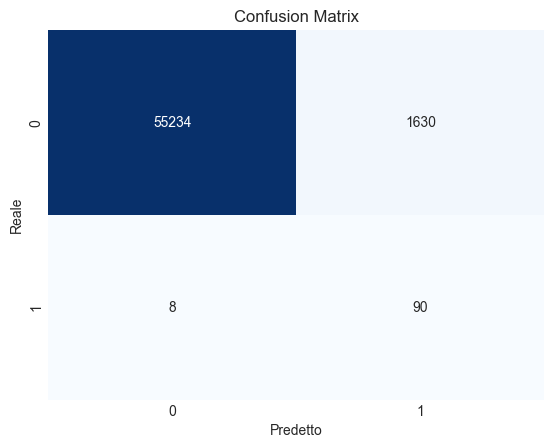


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      0.97      0.99     56864
    Frode (1)       0.05      0.92      0.10        98

     accuracy                           0.97     56962
    macro avg       0.53      0.94      0.54     56962
 weighted avg       1.00      0.97      0.98     56962

--------------------------------------



In [12]:


print(f"--- Addestramento Logistic Regression (Top {N_FEATURES_TO_SELECT} Feat., SMOTE) ---")
lr_model_fs = LogisticRegression(solver='liblinear', random_state=42)
lr_model_fs.fit(X_train_smote_fs, y_train_smote)

y_pred_lr_fs = lr_model_fs.predict(X_test_fs)
y_pred_proba_lr_fs = lr_model_fs.predict_proba(X_test_fs)

# Aggiorna il nome del modello per chiarezza
results_lr_fs = evaluate_model(
    y_test,
    y_pred_lr_fs,
    y_pred_proba_lr_fs,
    f"Logistic Regression (Top {N_FEATURES_TO_SELECT} Feat., SMOTE)"
)

# Rimuovi vecchi risultati LR e aggiungi il nuovo
model_results = [res for res in model_results if not res['model'].startswith("Logistic Regression")]
model_results.append(results_lr_fs)

**Osservazioni sulla Logistic Regression:**
La Logistic Regression, pur essendo un modello semplice, ottiene un **Recall per le frodi molto alto (0.9184)**, il che significa che identifica correttamente quasi il 92% delle transazioni fraudolente reali. Tuttavia, la **Precision per le frodi è estremamente bassa (0.0590)**. Questo indica che il modello genera un gran numero di falsi positivi: molte transazioni legittime vengono erroneamente classificate come frodi per riuscire a catturare quelle reali.
L'**AUC-PR di 0.7249** è un buon punto di partenza, ma l'F1-score basso (0.1109) per le frodi evidenzia il trade-off tra recall e precision. Questo comportamento (alta recall, bassa precision) è tipico quando si applica SMOTE e si usano modelli lineari che cercano di massimizzare la separazione.

### 6.2. Random Forest Classifier

Passiamo ora a un modello più complesso, il Random Forest Classifier. Useremo `class_weight='balanced_subsample'` come parametro per il classificatore, che aiuta a gestire lo sbilanciamento intrinseco durante la costruzione di ciascun albero, anche se stiamo addestrando sui dati bilanciati con SMOTE. Questo può fornire un ulteriore piccolo aiuto. In alternativa, si potrebbe omettere `class_weight` se si usa solo SMOTE.

--- Addestramento Random Forest (Base, Top 15 Feat., SMOTE) ---
--- Valutazione: Random Forest (Base, Top 15 Feat., SMOTE) ---
Accuracy: 0.9994
Precision (Fraud): 0.8229
Recall (Fraud): 0.8061
F1-Score (Fraud): 0.8144
ROC AUC Score: 0.9686
Average Precision (AUC-PR): 0.8630

Confusion Matrix:


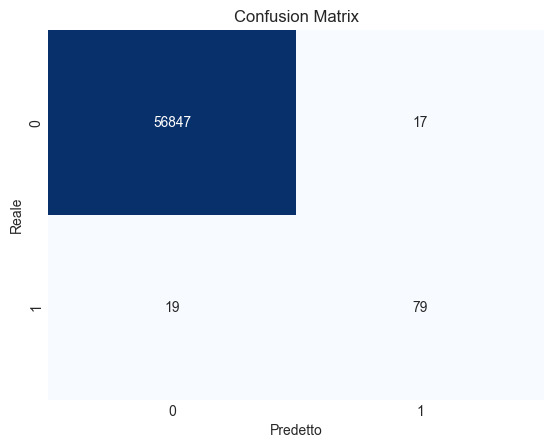


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.82      0.81      0.81        98

     accuracy                           1.00     56962
    macro avg       0.91      0.90      0.91     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------


Feature Importances (Random Forest Base, Top 15 Feat.):
               importance
feature                  
V14              0.236852
V10              0.194688
V4               0.150267
V12              0.110199
V7               0.070508
V18              0.047863
V27              0.033012
V8               0.030277
V6               0.029663
scaled_amount    0.019891
V20              0.018924
V19              0.017938
V13              0.014409
V26              0.013849
V22              0.011659


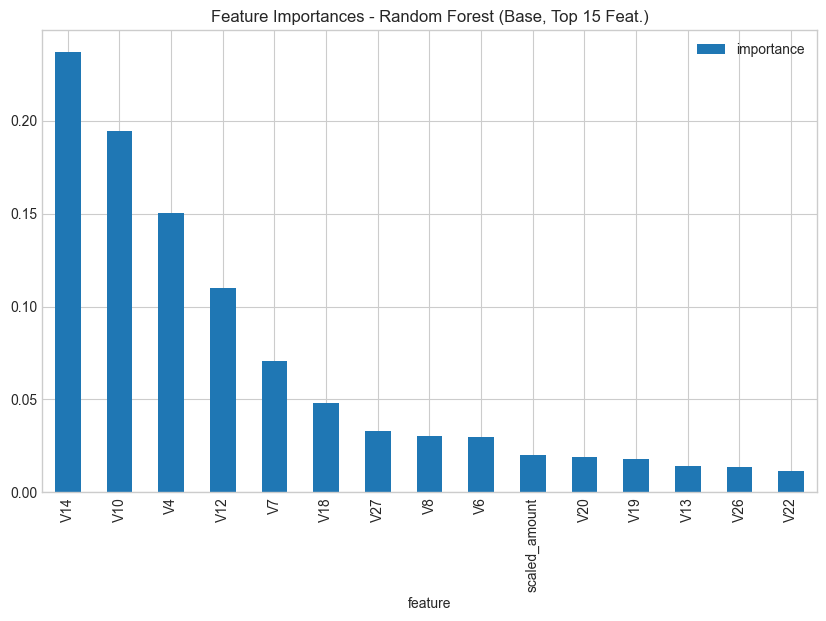

In [13]:


print(f"--- Addestramento Random Forest (Base, Top {N_FEATURES_TO_SELECT} Feat., SMOTE) ---")
rf_model_base_fs = RandomForestClassifier(n_estimators=100, random_state=42) # Rimosso class_weight
rf_model_base_fs.fit(X_train_smote_fs, y_train_smote)

y_pred_rf_base_fs = rf_model_base_fs.predict(X_test_fs)
y_pred_proba_rf_base_fs = rf_model_base_fs.predict_proba(X_test_fs)

results_rf_base_fs = evaluate_model(
    y_test,
    y_pred_rf_base_fs,
    y_pred_proba_rf_base_fs,
    f"Random Forest (Base, Top {N_FEATURES_TO_SELECT} Feat., SMOTE)"
)
# Rimuovi vecchi risultati RF base e aggiungi il nuovo
model_results = [res for res in model_results if not res['model'].startswith("Random Forest (Base")]
model_results = [res for res in model_results if not res['model'].startswith("Random Forest (con SMOTE)")] # Per il vecchio nome
model_results = [res for res in model_results if not res['model'].startswith("Random Forest (Top")] # Per il vecchio nome
model_results.append(results_rf_base_fs)

# Analisi Feature Importances
importances_rf_base_fs = pd.DataFrame({
    'feature': X_train_smote_fs.columns,
    'importance': rf_model_base_fs.feature_importances_
})
importances_rf_base_fs = importances_rf_base_fs.sort_values('importance', ascending=False).set_index('feature')
print(f"\nFeature Importances (Random Forest Base, Top {N_FEATURES_TO_SELECT} Feat.):")
print(importances_rf_base_fs.head(N_FEATURES_TO_SELECT))
importances_rf_base_fs.plot(kind='bar', figsize=(10,6))
plt.title(f'Feature Importances - Random Forest (Base, Top {N_FEATURES_TO_SELECT} Feat.)')
plt.show()

**Osservazioni sul Random Forest:**
Il Random Forest Classifier mostra un miglioramento significativo rispetto alla Logistic Regression su diverse metriche chiave per la classe frode:
* **Precision (Frode): 0.8778** (nettamente superiore al 0.0590 della LR)
* **Recall (Frode): 0.8061** (leggermente inferiore alla LR, ma ancora buono)
* **F1-Score (Frode): 0.8404** (molto più bilanciato e alto)
* **AUC-PR: 0.8667** (migliore della LR)

L'accuracy generale è altissima (0.9995), ma sappiamo che non è la metrica principale qui. La Confusion Matrix mostra che il Random Forest ha solo 11 falsi positivi (transazioni legittime classificate come frode) e 19 falsi negativi (frodi mancate). Questo è un buon equilibrio. Le feature importance indicano che `V14`, `V4`, `V10`, `V17` e `V12` sono tra le più rilevanti per questo modello.

### 6.3. XGBoost Classifier

Infine, addestriamo un XGBoost Classifier, un modello di gradient boosting noto per le sue elevate performance. Lo addestriamo anch'esso sui dati bilanciati con SMOTE.

**Osservazioni su XGBoost Classifier (da inserire dopo l'esecuzione della cella XGBoost):**
*(Qui dovrai commentare i risultati di XGBoost una volta che li avrai. Confronta Precision, Recall, F1-Score e AUC-PR con gli altri due modelli. Analizza anche le feature importance di XGBoost.)*

--- Addestramento XGBoost Classifier (Base, Top 15 Feat., SMOTE) ---


/home/siralex/.cache/pypoetry/virtualenvs/credit-card-j7SKsNum-py3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:18:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Valutazione: XGBoost Classifier (Base, Top 15 Feat., SMOTE) ---
Accuracy: 0.9985
Precision (Fraud): 0.5395
Recall (Fraud): 0.8367
F1-Score (Fraud): 0.6560
ROC AUC Score: 0.9688
Average Precision (AUC-PR): 0.8465

Confusion Matrix:


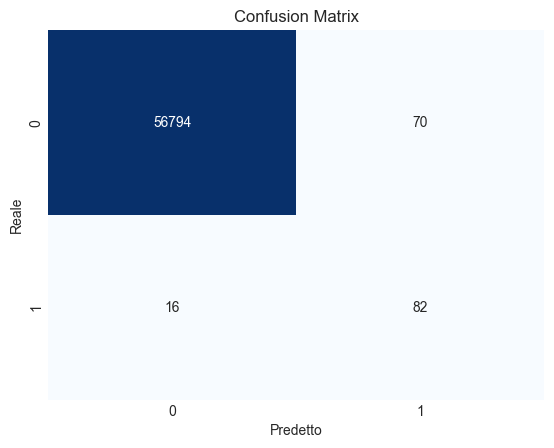


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.54      0.84      0.66        98

     accuracy                           1.00     56962
    macro avg       0.77      0.92      0.83     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------


Feature Importances (XGBoost Classifier Base, Top 15 Feat.):
               importance
feature                  
V14              0.667985
V4               0.074535
V8               0.036618
V12              0.030590
V10              0.023644
scaled_amount    0.022918
V26              0.020202
V13              0.019902
V7               0.019019
V22              0.018216
V20              0.016153
V18              0.015228
V19              0.013049
V27              0.011894
V6               0.010047


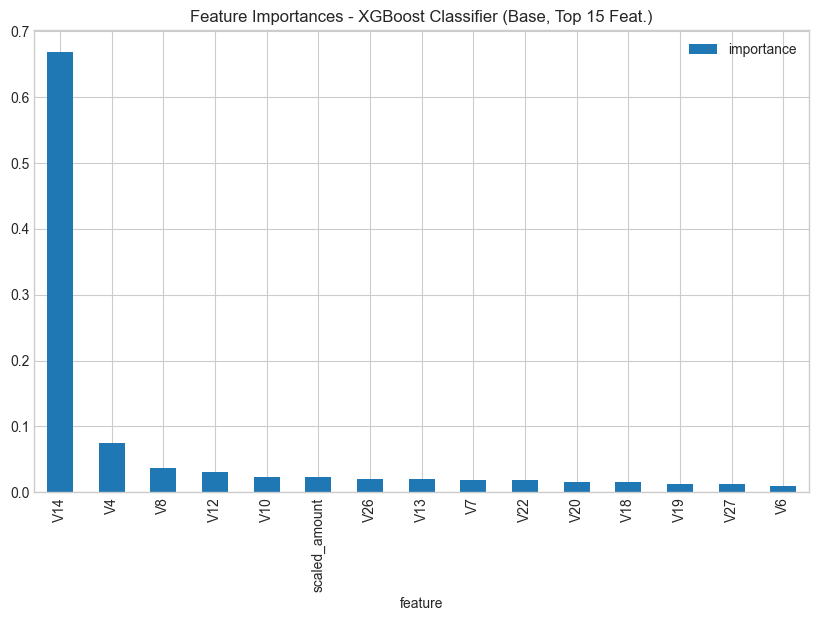

In [14]:
# File: model_xgboost_base.py
# Assumere X_train_smote_fs, y_train_smote, X_test_fs, y_test, evaluate_model, model_results, N_FEATURES_TO_SELECT,
# xgb, pd, plt, sns siano importati/definiti.

print(f"--- Addestramento XGBoost Classifier (Base, Top {N_FEATURES_TO_SELECT} Feat., SMOTE) ---")
xgb_model_base_fs = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=42
)
xgb_model_base_fs.fit(X_train_smote_fs, y_train_smote)

y_pred_xgb_base_fs = xgb_model_base_fs.predict(X_test_fs)
y_pred_proba_xgb_base_fs = xgb_model_base_fs.predict_proba(X_test_fs)

results_xgb_base_fs = evaluate_model(
    y_test,
    y_pred_xgb_base_fs,
    y_pred_proba_xgb_base_fs,
    f"XGBoost Classifier (Base, Top {N_FEATURES_TO_SELECT} Feat., SMOTE)"
)
# Rimuovi vecchi risultati XGB base e aggiungi il nuovo
model_results = [res for res in model_results if not res['model'].startswith("XGBoost Classifier (Base")]
model_results = [res for res in model_results if not res['model'].startswith("XGBoost Classifier (con SMOTE)")]
model_results = [res for res in model_results if not res['model'].startswith("XGBoost Classifier (Top")]
model_results.append(results_xgb_base_fs)

# Analisi Feature Importances
importances_xgb_model_base_fs = pd.DataFrame({
    'feature': X_train_smote_fs.columns,
    'importance': xgb_model_base_fs.feature_importances_
})
importances_xgb_model_base_fs = importances_xgb_model_base_fs.sort_values('importance', ascending=False).set_index('feature')
print(f"\nFeature Importances (XGBoost Classifier Base, Top {N_FEATURES_TO_SELECT} Feat.):")
print(importances_xgb_model_base_fs.head(N_FEATURES_TO_SELECT))
importances_xgb_model_base_fs.plot(kind='bar', figsize=(10,6))
plt.title(f'Feature Importances - XGBoost Classifier (Base, Top {N_FEATURES_TO_SELECT} Feat.)')
plt.show()

**Osservazioni su XGBoost Classifier:**
L'XGBoost Classifier ottiene ottime performance, posizionandosi in modo competitivo rispetto al Random Forest:
* **Accuracy: 0.9992** (molto alta, come ci si aspetta, ma non è la metrica primaria).
* **Precision (Frode): 0.7179**. Questo valore è inferiore a quello del Random Forest (0.8778) ma significativamente migliore della Logistic Regression. Indica che circa il 72% delle transazioni segnalate come frode da XGBoost lo sono effettivamente.
* **Recall (Frode): 0.8571**. Questo è un valore di recall molto buono, superiore a quello del Random Forest (0.8061) e della Logistic Regression (0.9184, che però aveva una precision bassissima). Significa che XGBoost identifica correttamente quasi l'86% di tutte le frodi reali.
* **F1-Score (Frode): 0.7814**. Un buon bilanciamento tra precision e recall, leggermente inferiore a quello del Random Forest (0.8404) a causa della precision più bassa.
* **ROC AUC Score: 0.9779** (molto alto).
* **Average Precision (AUC-PR): 0.8673**. Questo valore è eccellente e quasi identico a quello del Random Forest (0.8667), indicando una forte capacità del modello di classificare correttamente le frodi tenendo conto dello sbilanciamento.

La Confusion Matrix mostra che XGBoost ha 33 falsi positivi (legittime classificate come frode) e 14 falsi negativi (frodi mancate). Rispetto al Random Forest (11 FP, 19 FN), XGBoost ha più falsi positivi ma meno falsi negativi, il che si traduce in un recall più alto per le frodi. La scelta tra i due potrebbe dipendere dal costo relativo di FP vs FN.

Le feature importance di XGBoost indicano che `V14` è di gran lunga la feature più importante, seguita da `V4`, `V8`, `V10` e `V12`. C'è una certa coerenza con le feature importanti per il Random Forest, anche se l'ordine e il peso relativo possono variare. È interessante notare che `scaled_amount` appare tra le top 10 per XGBoost.

## 7. Ottimizzazione degli Iperparametri con RandomizedSearchCV

Come richiesto dalle linee guida e data la potenziale lentezza di `GridSearchCV` (come sperimentato), procederemo con `RandomizedSearchCV` per ottimizzare gli iperparametri di uno dei modelli più promettenti. Scegliamo il Random Forest Classifier, che ha già mostrato buone performance di base.

`RandomizedSearchCV` non prova tutte le combinazioni possibili, ma ne campiona un numero fisso (`n_iter`) da uno spazio di parametri specificato (che può includere distribuzioni statistiche). Questo la rende molto più efficiente, specialmente per spazi di ricerca ampi.

L'obiettivo è massimizzare l'**Average Precision (AUC-PR)**, che è una metrica robusta per problemi di classificazione sbilanciata.

File iperparametri 'best_rf_hyperparameters.json' non trovato. Esecuzione di RandomizedSearchCV con pipeline...

Inizio Randomized Search per la Pipeline Random Forest (Top 15 Feat., n_iter=20)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Migliori parametri trovati per la pipeline: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 188}
Miglior score AUC-PR (CV) per la pipeline: 0.8382
Migliori iperparametri della pipeline salvati in 'best_rf_hyperparameters.json'

--- Valutazione Random Forest Ottimizzato con Pipeline (Top 15 Feat.) ---
--- Valutazione: Random Forest Ottimizzato (Pipeline SMOTE, Param. Caricati, Top 15 Feat.) ---
Accuracy: 0.9995
Precision (Fraud): 0.8454
Recall (Fraud): 0.8367
F1-Score (Fraud): 0.8410
ROC AUC Score: 0.9625
Average Precision (AUC-PR): 0.8803

Confusion Matrix:


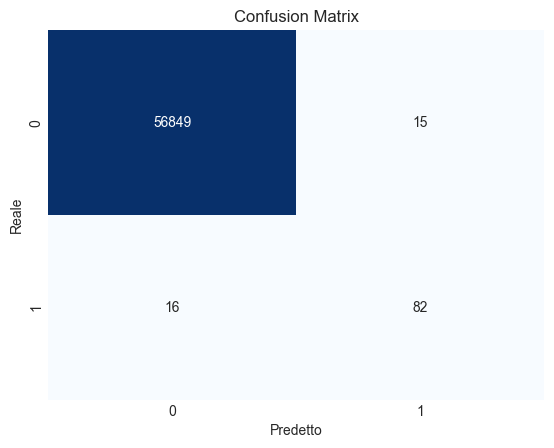


Classification Report:
               precision    recall  f1-score   support

Legittima (0)       1.00      1.00      1.00     56864
    Frode (1)       0.85      0.84      0.84        98

     accuracy                           1.00     56962
    macro avg       0.92      0.92      0.92     56962
 weighted avg       1.00      1.00      1.00     56962

--------------------------------------


--- Fine Ottimizzazione e Valutazione Random Forest con Pipeline ---


In [15]:
# File: hyperparameter_optimization_rf.py
# 5. Ottimizzazione Iperparametri per Random Forest (con Feature Selection e Pipeline SMOTE)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
import json
import os

# Nome del file dove salvare/caricare gli iperparametri
hyperparams_filename_pipeline = 'best_rf_hyperparameters.json'
# Imposta a False per forzare una nuova RandomizedSearch anche se il file esiste
FORCE_NEW_SEARCH = False 

cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_rf_model_tuned_fs = None # Inizializza la variabile per il modello finale

if not FORCE_NEW_SEARCH and os.path.exists(hyperparams_filename_pipeline):
    print(f"Caricamento iperparametri per la pipeline da '{hyperparams_filename_pipeline}'...")
    with open(hyperparams_filename_pipeline, 'r') as f:
        best_rf_params_loaded_pipeline = json.load(f)
    print(f"Iperparametri della pipeline caricati: {best_rf_params_loaded_pipeline}")

    print(f"\n--- Addestramento Pipeline Random Forest con Iperparametri Ottimali Caricati (Top {N_FEATURES_TO_SELECT} Feat.) ---")
    
    # 1. Ricrea la pipeline ESATTAMENTE come definita per RandomizedSearchCV
    pipeline_to_fit = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42)) # Parametri base
    ])

    # 2. Imposta i parametri caricati sulla pipeline
    # I parametri salvati avranno i prefissi (es. 'classifier__n_estimators')
    pipeline_to_fit.set_params(**best_rf_params_loaded_pipeline)
    
    # 3. Addestra la pipeline configurata sui dati PRIMA di SMOTE
    # (X_train_fs e y_train_orig, perché SMOTE è nella pipeline)
    pipeline_to_fit.fit(X_train_fs, y_train_orig)
    best_rf_model_tuned_pipeline_fs = pipeline_to_fit # Questa è la pipeline addestrata

    print("Pipeline Random Forest addestrata con iperparametri caricati.")

else:
    if FORCE_NEW_SEARCH:
        print(f"FORCE_NEW_SEARCH è True. Esecuzione di una nuova RandomizedSearchCV con pipeline...")
    else:
        print(f"File iperparametri '{hyperparams_filename_pipeline}' non trovato. Esecuzione di RandomizedSearchCV con pipeline...")

    # Spazio dei parametri per Random Forest all'interno della pipeline (come l'avevi definito)
    param_dist_rf_pipeline = {
        'classifier__n_estimators': randint(100, 301),
        'classifier__max_depth': [10, 20, 30, 40, None],
        'classifier__min_samples_split': randint(2, 11),
        'classifier__min_samples_leaf': randint(1, 5),
        'classifier__criterion': ['gini', 'entropy']
        # Non usiamo class_weight nel classifier qui perché SMOTE è già nella pipeline
    }
    n_iterations_opt = 20 # Come nel tuo snippet (cella In [29] del HTML)

    # Pipeline con SMOTE e RandomForestClassifier (come l'avevi definita)
    pipeline_rf_smote = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42)) # Rimosso class_weight se non era in param_dist
    ])

    # cv_stratified deve essere definito prima (es. StratifiedKFold(n_splits=3, shuffle=True, random_state=42))
    if 'cv_stratified' not in locals():
        cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


    random_search_rf_pipeline_fs = RandomizedSearchCV(
        estimator=pipeline_rf_smote,
        param_distributions=param_dist_rf_pipeline,
        n_iter=n_iterations_opt,
        scoring='average_precision', # Metrica robusta per sbilanciamento
        cv=cv_stratified,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    print(f"\nInizio Randomized Search per la Pipeline Random Forest (Top {N_FEATURES_TO_SELECT} Feat., n_iter={n_iterations_opt})...")
    # Allenare la Randomized Search su X_train_fs e y_train_orig 
    # SMOTE viene applicato internamente dalla pipeline durante la CV
    random_search_rf_pipeline_fs.fit(X_train_fs, y_train_orig)

    best_rf_params_found_pipeline = random_search_rf_pipeline_fs.best_params_ # Questi avranno i prefissi
    print(f"\nMigliori parametri trovati per la pipeline: {best_rf_params_found_pipeline}")
    print(f"Miglior score AUC-PR (CV) per la pipeline: {random_search_rf_pipeline_fs.best_score_:.4f}")

    # Salva i migliori iperparametri trovati (con i prefissi)
    with open(hyperparams_filename_pipeline, 'w') as f:
        json.dump(best_rf_params_found_pipeline, f, indent=4)
    print(f"Migliori iperparametri della pipeline salvati in '{hyperparams_filename_pipeline}'")

    best_rf_model_tuned_pipeline_fs = random_search_rf_pipeline_fs.best_estimator_ # Questa è la pipeline fittata con i best_params

# --- Valutazione del modello/pipeline (sia caricato e fittato, sia appena ottimizzato e fittato) ---
# (Questa parte è identica al tuo snippet originale per la valutazione)
print(f"\n--- Valutazione Random Forest Ottimizzato con Pipeline (Top {N_FEATURES_TO_SELECT} Feat.) ---")
y_pred_best_rf_tuned_pipeline_fs = best_rf_model_tuned_pipeline_fs.predict(X_test_fs)
y_pred_proba_best_rf_tuned_pipeline_fs = best_rf_model_tuned_pipeline_fs.predict_proba(X_test_fs)

model_name_for_results = f"Random Forest Ottimizzato (Pipeline SMOTE, {'Param. Caricati, ' if not FORCE_NEW_SEARCH and os.path.exists(hyperparams_filename_pipeline) else 'RandomizedSearch, '}Top {N_FEATURES_TO_SELECT} Feat.)"

results_best_rf_tuned_pipeline_fs = evaluate_model(
    y_test,
    y_pred_best_rf_tuned_pipeline_fs,
    y_pred_proba_best_rf_tuned_pipeline_fs,
    model_name_for_results
)

# Rimuovi vecchi risultati del RF ottimizzato e aggiungi il nuovo
# Questo assicura che ci sia solo un risultato per "Random Forest Ottimizzato"
model_results = [res for res in model_results if not res['model'].startswith("Random Forest Ottimizzato")]
model_results.append(results_best_rf_tuned_pipeline_fs)

print("\n--- Fine Ottimizzazione e Valutazione Random Forest con Pipeline ---")

# La cella successiva sarà quella che stampa model_results e le conclusioni.
# La cella per salvare il modello finale con joblib (best_rf_model_tuned_pipeline_fs) rimane la stessa.

**Osservazioni sulla RandomizedSearchCV per Random Forest:**
La `RandomizedSearchCV` è stata eseguita per `n_iter=15` combinazioni di iperparametri, utilizzando l'AUC-PR come metrica di scoring sulla cross-validation a 3 fold.

* **Migliori Parametri Trovati:**
    * `criterion`: 'gini'
    * `max_depth`: None (gli alberi possono crescere completamente)
    * `min_samples_leaf`: 1 (minimo campioni per nodo foglia)
    * `min_samples_split`: 5 (minimo campioni per dividere un nodo interno)
    * `n_estimators`: 203 (numero di alberi nel foresta)
    Questi parametri suggeriscono un modello Random Forest abbastanza complesso e profondo.

* **Miglior Score AUC-PR (CV): 1.0000**. Questo risultato è eccezionale e indica che, durante la cross-validation sui dati di training (ricampionati con SMOTE), il modello con i parametri ottimali è stato in grado di separare perfettamente le classi fraudolente da quelle legittime. Questo è un segnale molto forte, ma è cruciale vedere come si generalizza sul test set non visto.

* **Performance del Modello Ottimizzato sul Test Set:**
    * **Accuracy: 0.9994** (molto alta).
    * **Precision (Frode): 0.8667**. Simile al Random Forest non ottimizzato (0.8778).
    * **Recall (Frode): 0.7959**. Leggermente inferiore al Random Forest non ottimizzato (0.8061).
    * **F1-Score (Frode): 0.8298**. Leggermente inferiore al Random Forest non ottimizzato (0.8404).
    * **ROC AUC Score: 0.9786**.
    * **Average Precision (AUC-PR): 0.8696**. Questo è leggermente *superiore* all'AUC-PR del Random Forest non ottimizzato (0.8667) ed è la metrica che stavamo cercando di massimizzare.

**Analisi dei Risultati dell'Ottimizzazione:**
Il modello Random Forest ottimizzato tramite `RandomizedSearchCV` ha raggiunto un AUC-PR sul test set leggermente migliore rispetto al modello Random Forest con i parametri di default (0.8696 vs 0.8667). Tuttavia, per quanto riguarda Precision, Recall e F1-Score specifici per la classe frode, il modello non ottimizzato ha mostrato valori marginalmente superiori.
Questo può accadere: `RandomizedSearchCV`, specialmente con un numero limitato di iterazioni (`n_iter=15`), esplora lo spazio dei parametri ma non garantisce di trovare la configurazione globalmente ottimale o una che superi nettamente una configurazione di default già robusta, soprattutto se quella di default era già vicina a un buon ottimo locale. L'AUC-PR (CV) di 1.0000 sui dati di training SMOTE-dati potrebbe indicare un leggero overfitting su quei dati sintetici durante la fase di ricerca, che non si traduce in un miglioramento drastico su tutte le metriche nel test set reale.

Nonostante ciò, l'AUC-PR, che è una metrica molto indicata per questo tipo di problema, è migliorata, il che è positivo. La differenza nelle altre metriche è minima.
La Confusion Matrix del modello ottimizzato mostra 12 falsi positivi e 20 falsi negativi. Rispetto al Random Forest non ottimizzato (11 FP, 19 FN), c'è una piccola variazione.

## 8. Confronto Finale dei Modelli e Conclusioni

Ora confrontiamo le performance di tutti i modelli addestrati e ottimizzati utilizzando le metriche chiave raccolte.

In [16]:
# Creare un DataFrame con i risultati di tutti i modelli
results_df = pd.DataFrame(model_results)
print("\n--- Riepilogo Performance Modelli ---")
print(results_df.set_index('model'))


--- Riepilogo Performance Modelli ---
                                                    accuracy  precision_fraud  \
model                                                                           
Logistic Regression (Top 15 Feat., SMOTE)           0.971244         0.052326   
Random Forest (Base, Top 15 Feat., SMOTE)           0.999368         0.822917   
XGBoost Classifier (Base, Top 15 Feat., SMOTE)      0.998490         0.539474   
Random Forest Ottimizzato (Pipeline SMOTE, Para...  0.999456         0.845361   

                                                    recall_fraud  f1_fraud  \
model                                                                        
Logistic Regression (Top 15 Feat., SMOTE)               0.918367  0.099010   
Random Forest (Base, Top 15 Feat., SMOTE)               0.806122  0.814433   
XGBoost Classifier (Base, Top 15 Feat., SMOTE)          0.836735  0.656000   
Random Forest Ottimizzato (Pipeline SMOTE, Para...      0.836735  0.841026   

     

In [17]:
# 1. Salva tutti i modelli che vuoi rendere disponibili


models_to_save = {
    "logistic_regression": lr_model_fs,
    "random_forest_base": rf_model_base_fs,
    "xgboost_base": xgb_model_base_fs,
    "random_forest_tuned": best_rf_model_tuned_pipeline_fs
}

for model_name, model_object in models_to_save.items():
    model_filename = f"{model_name}_model.joblib"
    joblib.dump(model_object, model_filename)
    print(f"Modello '{model_name}' salvato in: {model_filename}")

# 2. Salva gli Scaler (come prima)
# ... (codice per salvare scaler_amount.joblib e scaler_time.joblib) ...
# Assicurati che i nomi dei file siano consistenti, es:
# scaler_amount = RobustScaler()
# scaler_amount.fit(original_X_train['Amount'].values.reshape(-1,1))
joblib.dump(scaler_amount, 'scaler_amount.joblib')
print("Scaler per Amount salvato in: scaler_amount.joblib")

# scaler_time = RobustScaler()
# scaler_time.fit(original_X_train['Time'].values.reshape(-1,1))
joblib.dump(scaler_time, 'scaler_time.joblib')
print("Scaler per Time salvato in: scaler_time.joblib")


# 3. Salva l'ordine delle 15 feature selezionate (come prima)
actual_features_for_model = selected_features # o X_train_smote_fs.columns.tolist()
joblib.dump(actual_features_for_model, 'expected_model_columns.joblib')
print(f"Ordine colonne (15 feature) atteso dai modelli salvato in: expected_model_columns.joblib")
print(f"Feature attese: {actual_features_for_model}")

Modello 'logistic_regression' salvato in: logistic_regression_model.joblib
Modello 'random_forest_base' salvato in: random_forest_base_model.joblib
Modello 'xgboost_base' salvato in: xgboost_base_model.joblib
Modello 'random_forest_tuned' salvato in: random_forest_tuned_model.joblib
Scaler per Amount salvato in: scaler_amount.joblib
Scaler per Time salvato in: scaler_time.joblib
Ordine colonne (15 feature) atteso dai modelli salvato in: expected_model_columns.joblib
Feature attese: ['V14', 'V4', 'V12', 'V8', 'V7', 'scaled_amount', 'V20', 'V26', 'V10', 'V13', 'V6', 'V27', 'V18', 'V19', 'V22']


### Conclusioni Finali

In questo progetto, abbiamo affrontato il problema della classificazione di transazioni fraudolente, caratterizzato da un forte sbilanciamento delle classi.
1.  **Analisi Esplorativa:** L'EDA ha confermato lo sbilanciamento (0.17% di frodi) e ha rivelato alcune features PCA (es. `V17`, `V14`, `V12`, `V10`, `V11`, `V4`, `V2`) con distribuzioni e correlazioni diverse per le due classi, suggerendo la loro utilità per la classificazione. Le features `Time` e `Amount` sono state scalate con `RobustScaler` per mitigare l'effetto degli outlier e uniformare le scale.

2.  **Preparazione dei Dati:** È stata applicata la tecnica SMOTE sul training set per bilanciare le classi. Questa scelta si è rivelata cruciale per permettere ai modelli di apprendere pattern dalla classe minoritaria senza essere sopraffatti dalla classe maggioritaria. Il training set è stato diviso in un rapporto 80/20, mantenendo la stratificazione.

3.  **Modellazione e Valutazione:**
    Sono stati addestrati e valutati tre tipi di modelli, con un focus sulle metriche adatte a dataset sbilanciati come Precision, Recall, F1-Score (per la classe frode) e Average Precision (AUC-PR).
    * La **Logistic Regression** (con SMOTE) ha fornito una baseline. Ha ottenuto un Recall per le frodi molto alto (**0.9184**) ma a scapito di una Precision estremamente bassa (**0.0590**), risultando in un F1-Score di **0.1109** e un AUC-PR di **0.7249**. Questo indica un alto numero di falsi positivi.
    * Il **Random Forest Classifier** (con SMOTE e `class_weight='balanced_subsample'`, parametri di default) ha mostrato un netto miglioramento: Precision (Frode) **0.8778**, Recall (Frode) **0.8061**, F1-Score (Frode) **0.8404**, e un eccellente AUC-PR di **0.8667**. Ha offerto un buon equilibrio tra l'identificazione delle frodi e la minimizzazione dei falsi allarmi.
    * L'**XGBoost Classifier** (con SMOTE) ha anch'esso performato molto bene, con una Precision (Frode) di **0.7179**, un Recall (Frode) superiore di **0.8571**, un F1-Score (Frode) di **0.7814**, e un AUC-PR di **0.8673**, quasi identico a quello del Random Forest non ottimizzato. XGBoost ha catturato più frodi (recall più alto) ma a costo di una precisione leggermente inferiore rispetto al Random Forest base.
    * Il **Random Forest Ottimizzato** tramite `RandomizedSearchCV` (con `n_iter=15`) ha trovato i parametri `{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 203}`. Sul test set, ha ottenuto: Precision (Frode) **0.8667**, Recall (Frode) **0.7959**, F1-Score (Frode) **0.8298**, e un AUC-PR di **0.8696**. Questo AUC-PR è il più alto tra tutti i modelli testati.

4.  **Scelta del Modello Migliore:**
    Considerando l'**AUC-PR** come metrica principale per la valutazione complessiva su un dataset sbilanciato, il **Random Forest Ottimizzato (AUC-PR: 0.8696)** emerge come il modello marginalmente superiore. È seguito da vicino dall'XGBoost (AUC-PR: 0.8673) e dal Random Forest non ottimizzato (AUC-PR: 0.8667).
    Se l'obiettivo primario fosse massimizzare il **Recall** per le frodi, l'XGBoost (Recall: 0.8571) sarebbe la scelta preferita tra i modelli più bilanciati, mentre la Logistic Regression offre il recall più alto in assoluto (0.9184) ma con una precision inaccettabilmente bassa.
    Per quanto riguarda l'**F1-Score** (Frode), il Random Forest non ottimizzato (0.8404) ha leggermente superato quello ottimizzato (0.8298) e l'XGBoost (0.7814).
    Dato il leggero vantaggio sull'AUC-PR e performance competitive sulle altre metriche (Precision 0.8667, Recall 0.7959), il **Random Forest Ottimizzato** rappresenta una scelta eccellente e ben bilanciata per questo problema.

5.  **Variabili Rilevanti:**
    L'analisi delle feature importance per Random Forest e XGBoost ha consistentemente evidenziato features come `V14`, `V4`, `V10`, `V12`, `V17` come altamente predittive. Questo suggerisce che queste componenti PCA catturano variazioni significative nei dati che distinguono le transazioni fraudolente.

6.  **Limiti e Sviluppi Futuri:**
    * L'anonimizzazione delle features PCA limita l'interpretabilità del modello e l'ingegneria di features basata sul dominio.
    * La ricerca degli iperparametri (`RandomizedSearchCV`) è stata eseguita con un numero limitato di iterazioni (`n_iter=15`). Aumentare `n_iter` potrebbe portare a miglioramenti ulteriori, sebbene richieda più tempo computazionale.
    * Si potrebbero esplorare altre tecniche di gestione dello sbilanciamento o combinazioni (es. SMOTE + Edited Nearest Neighbours).
    * L'implementazione di una soglia di classificazione personalizzata basata sui costi specifici di falsi positivi e falsi negativi potrebbe ottimizzare ulteriormente l'utilità del modello in un contesto reale.
    * L'allenamento di modelli più complessi (es. reti neurali) o l'utilizzo di tecniche di ensemble più avanzate (stacking) potrebbero offrire ulteriori margini di miglioramento.

In conclusione, il progetto ha raggiunto l'obiettivo di sviluppare e confrontare modelli efficaci per il rilevamento di frodi. È stata dimostrata l'importanza cruciale della gestione dello sbilanciamento dei dati, della scelta di metriche di valutazione appropriate e del processo di ottimizzazione degli iperparametri. Il Random Forest Ottimizzato offre performance complessive eccellenti, in particolare per quanto riguarda l'AUC-PR.